# Gradcam interp

In [39]:
from audiointerp.dataset.esc50 import ESC50dataset
from audiointerp.model.cnn14 import TransferCnn14
from audiointerp.interpretation.gradcam import GradCAMInterpreter
import torch.nn as nn
import torch.optim as optim
import torchaudio.transforms as T
import torch.nn.functional as F
import torchaudio.functional as F_audio
import torch
import torchaudio
from torch.utils.data import DataLoader
from tqdm import tqdm
from IPython.display import Audio
import os
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
root_dir = "/home/yuliya/ESC50"
sr = 32000
test_folds = [5]

In [4]:
n_fft = 1024
hop_length = 320
win_length = 1024
n_mels = 64
f_min = 50
f_max = 14000

In [5]:
spec = T.Spectrogram(n_fft=n_fft, win_length=win_length, hop_length=hop_length, power=2.0)
mel = T.MelScale(n_mels=n_mels, sample_rate=sr, f_min=f_min, f_max=f_max, n_stft=n_fft // 2 + 1)
amplitude_to_db = T.AmplitudeToDB(stype="power", top_db=80)

In [6]:
feature_extractor = nn.Sequential(spec, mel, amplitude_to_db)

In [7]:
test_data = ESC50dataset(root_dir=root_dir, sr=sr, folds=test_folds, feature_extractor=feature_extractor)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [8]:
model = TransferCnn14(50)
model.to(device)
model.load_state_dict(torch.load("best.pth"))

<All keys matched successfully>

In [9]:
criterion = nn.CrossEntropyLoss()

In [10]:
def valid_step(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0
    
    with torch.no_grad():
        for samples, labels in dataloader:
            samples = samples.to(device)
            labels = labels.to(device)
            
            outputs = model(samples)
            loss = criterion(outputs, labels)
            
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * samples.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += samples.size(0)
    
    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.double() / total_samples
    
    return epoch_loss, epoch_acc.item()

In [11]:
test_loss, test_acc = valid_step(model, criterion, test_loader, device)
print(f"Test loss: {test_loss:.2f}, Test acc: {test_acc:.2f}")

Test loss: 0.57, Test acc: 0.88


In [12]:
def compute_logit_difference(model, test_loader, device):
    model.eval()
    model.to(device)

    target_layers = [model.base.conv_block6.conv2]
    
    gradcam = GradCAMInterpreter(model=model, target_layers=target_layers)
    results = []
    
    for inputs, _ in test_loader:
        inputs = inputs.to(device).requires_grad_(True)
        
        logits = model(inputs)
        predicted_class = logits.argmax(dim=1)

        mask = gradcam.interpret(inputs)["masks"]

        masked_inputs = inputs * (1 - mask)
    
        logits_original = model(inputs)
        logits_masked = model(masked_inputs)
        
        logit_diff = logits_original.gather(1, predicted_class.unsqueeze(1)) - \
                     logits_masked.gather(1, predicted_class.unsqueeze(1))
        
        results.append(logit_diff.cpu().detach())
    
    return torch.cat(results)

In [13]:
results = compute_logit_difference(model, test_loader, device)

In [14]:
results.mean()

tensor(9.5587)

In [15]:
torch.sum(results > 0)

tensor(384)

## Predict for samples

In [37]:
target_to_label = {0: "dog", 14: "chirping_birds", 36: "vacuum_cleaner", 19: "thunderstorm", 30: 'door_wood_knock', 34: 'can_opening',
                   9: 'crow', 22: 'clapping',48: 'fireworks', 41: 'chainsaw', 47: 'airplane', 31: 'mouse_click', 17: 'pouring_water',
                   45: 'train', 8: 'sheep', 15: 'water_drops', 46: 'church_bells', 37: 'clock_alarm', 32: 'keyboard_typing', 16: 'wind',
                   25: 'footsteps', 4: 'frog', 3: 'cow', 27: 'brushing_teeth', 43: 'car_horn', 12: 'crackling_fire', 40: 'helicopter', 29: 'drinking_sipping',
                   10: 'rain', 7: 'insects', 26: 'laughing', 6: 'hen', 44: 'engine', 23: 'breathing', 20: 'crying_baby',
                   49: 'hand_saw', 24: 'coughing', 39: 'glass_breaking', 28: 'snoring', 18: 'toilet_flush', 2: 'pig', 35: 'washing_machine',
                   38: 'clock_tick', 21: 'sneezing', 1: 'rooster', 11: 'sea_waves', 42: 'siren', 5: 'cat', 33: 'door_wood_creaks', 13: 'crickets'}

In [ ]:
def extract_features(input):

    stft_complex = torch.stft(input, n_fft=n_fft, hop_length=hop_length, win_length=win_length, return_complex=True)
    
    

In [56]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()
    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1, figsize=(8, 4))
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
          axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
          axes[c].set_xlim(xlim)
        if ylim:
          axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

In [108]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(1, 1, figsize=(10, 4))
    axs.set_title(title or 'Spectrogram (db)')
    axs.set_ylabel(ylabel)
    axs.set_xlabel('frame')
    im = axs.imshow(spec, origin='lower', aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [175]:
def plot_two_spectrograms(spec1, spec2, title1="Spectrogram 1", title2="Spectrogram 2", ylabel='freq_bin', aspect='auto', xmax=None):
    fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    vmin = min(spec1.min(), spec2.min())
    vmax = max(spec1.max(), spec2.max())

    im1 = axs[0].imshow(spec1, origin='lower', aspect=aspect, vmin=vmin, vmax=vmax)
    axs[0].set_title(title1)
    axs[0].set_ylabel(ylabel)

    im2 = axs[1].imshow(spec2, origin='lower', aspect=aspect, vmin=vmin, vmax=vmax)
    axs[1].set_title(title2)
    axs[1].set_ylabel(ylabel)
    axs[1].set_xlabel('frame')

    if xmax:
        axs[0].set_xlim((0, xmax))
        axs[1].set_xlim((0, xmax))

    fig.colorbar(im1, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)

    plt.show(block=False)

In [467]:
def get_attribution(model, input):
    input = input.to(device)
    
    target_layers = [model.base.conv_block6.conv2]
    gradcam = GradCAMInterpreter(model=model, target_layers=target_layers)

    result = gradcam.interpret(input)
    attrs = result["ints"]
    mask = result["masks"]

    masked = attrs * (input - input.min()) + input.min()

    return attrs, masked

In [468]:
samples_dir = "samples"
filename = "car_horn.wav"

In [469]:
audio, original_sr = torchaudio.load(os.path.join(samples_dir, filename))
if audio.shape[0] > 1:
    audio = torch.mean(audio, dim=0, keepdim=True)

if original_sr != sr:
    audio = F_audio.resample(audio, original_sr, sr)

In [470]:
Audio(audio[0], rate=sr)

In [471]:
stft_complex = torch.stft(input=audio, n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=torch.hann_window(win_length), return_complex=True)
amplitudes = torch.abs(stft_complex)
phases = torch.atan2(stft_complex.imag, stft_complex.real)
melspec = mel(amplitudes.pow(2))
melspec_db = amplitude_to_db(melspec)

In [472]:
model_input = melspec_db.unsqueeze(0)

In [473]:
with torch.no_grad():
    logits = model(model_input.to(device))
predicted_class = logits.argmax(dim=1).item()

In [474]:
print(f"Predicted class for {filename}: {predicted_class} ({target_to_label[predicted_class]})")

Predicted class for car_horn.wav: 43 (car_horn)


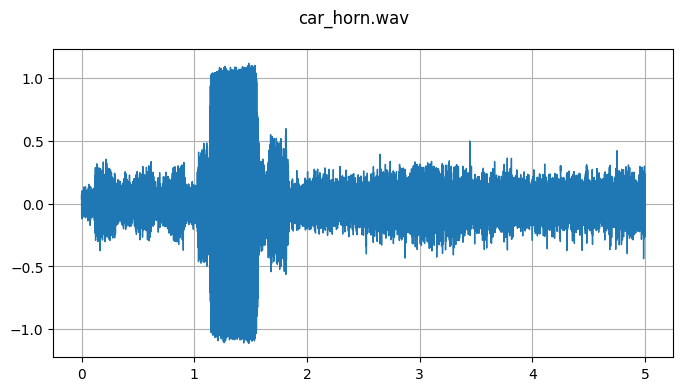

In [475]:
plot_waveform(audio, sr, f"{filename}")

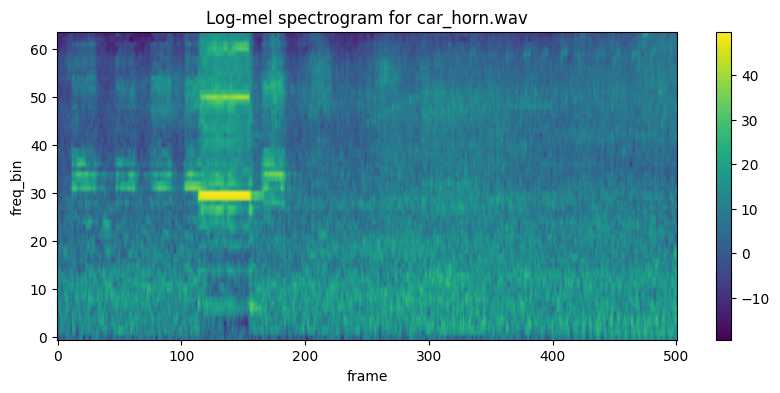

In [476]:
plot_spectrogram(melspec_db[0], f"Log-mel spectrogram for {filename}")

In [477]:
attrs, masked = get_attribution(model, model_input)

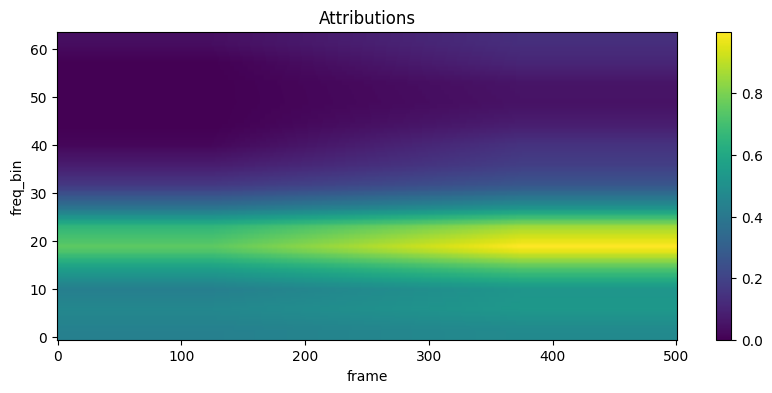

In [478]:
plot_spectrogram(attrs[0][0].cpu(), "Attributions")

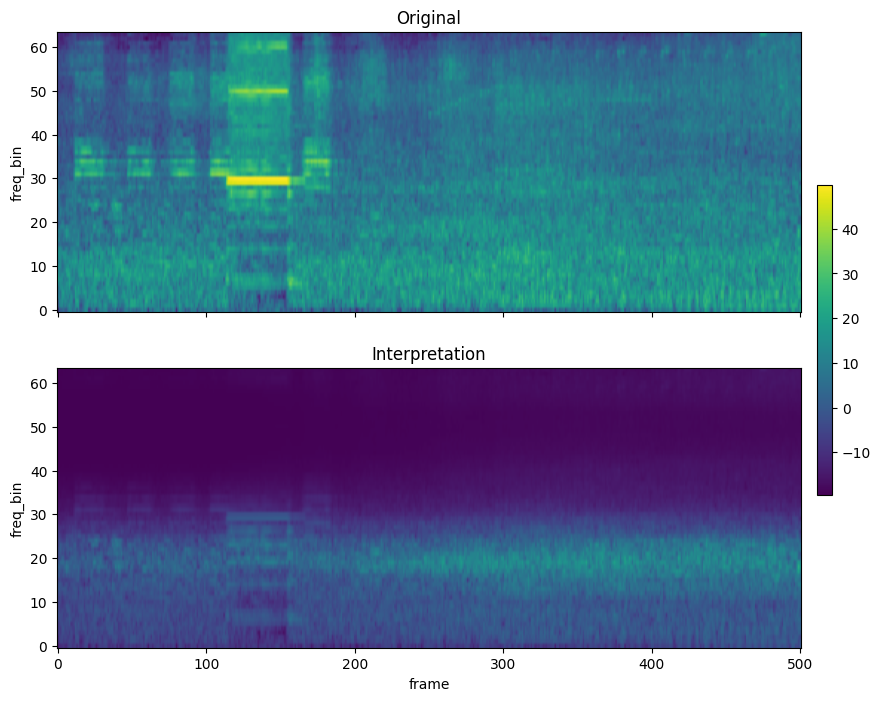

In [479]:
plot_two_spectrograms(melspec_db[0], masked[0][0].detach().cpu(), "Original", "Interpretation")

In [480]:
def db_to_amplitude(x_db, multiplier=10.0, amin=1e-10, db_multiplier=0.0, top_db=None):
    if top_db is not None:
        max_db = x_db.amax(dim=(-3, -2, -1), keepdim=True)
        min_possible_db = max_db - top_db
        x_db = torch.maximum(x_db, min_possible_db)

    x_db += multiplier * db_multiplier

    amplitude = torch.pow(10.0, x_db / multiplier)

    return amplitude

In [481]:
inverse_mel = T.InverseMelScale(n_stft= n_fft // 2 + 1, n_mels=n_mels, sample_rate=sr, f_min=f_min, f_max=f_max)

In [482]:
interp_spec= inverse_mel(db_to_amplitude(masked.cpu(), top_db=80))

In [483]:
interp_audio = torch.istft(torch.polar(interp_spec[0].abs(), phases), n_fft=n_fft, hop_length=hop_length, win_length=win_length, window=torch.hann_window(win_length))

In [484]:
Audio(audio, rate=sr)

In [485]:
Audio(interp_audio.detach(), rate=sr)